In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

This is a template for your final project.

In [2]:
full_dataset = pd.read_csv('IMDb movies.csv')
full_dataset

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60193,tt1836907,Sài Gòn Yo!,Sài Gòn Yo!,2011,2011-04-22,Drama,106,Vietnam,Vietnamese,Stephane Gauger,...,"Quynh Hoa, Khuong Ngoc, Elly Nguyen, Phan Tan ...","Mai, a ribbon dancer from the countryside arri...",6.8,106,$ 500000,NaN,NaN,NaN,3.0,4.0
60194,tt1836912,Shaitan,Shaitan,2011,2011-06-10,"Action, Crime, Drama",121,India,"Hindi, English",Bejoy Nambiar,...,"Kalki Koechlin, Shiv Panditt, Gulshan Devaiah,...",Five substance-abusing friends decide to fake ...,7.2,7615,NaN,NaN,NaN,NaN,42.0,15.0
60195,tt1836918,Slow Action,Slow Action,2011,2011-01-28,Sci-Fi,45,UK,English,Ben Rivers,...,NaN,NaN,6.8,107,GBP 30000,NaN,NaN,NaN,4.0,6.0
60196,tt1836926,Stealing Las Vegas,Stealing Las Vegas,2012,2012-09-11,"Crime, Thriller",87,USA,English,Francisco Menéndez,...,"Eric Roberts, Antonio Fargas, Ethan Landry, An...",When a greedy Las Vegas casino owner threatens...,3.9,354,NaN,NaN,NaN,NaN,10.0,4.0


### Part 1.

Task formalization and Evaluation criteria

1.1 Select your target variable, explain your choice. Separate target variable from the feature matrix.

<AxesSubplot:>

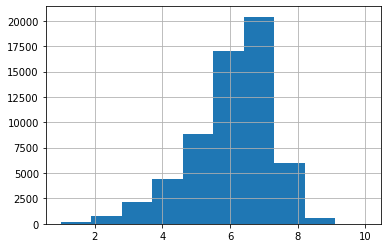

In [3]:
full_dataset.avg_vote.hist()

In [4]:
y = full_dataset["avg_vote"].apply(lambda x: 1 if x>=7 else 0)
full_dataset = full_dataset.drop("avg_vote", axis = 1)
# target variable will be binary, produced from avg_vote. We will predict what type of avg_score film will get.
# If avg_score > 7 -> label = 1, else label = 0

In [5]:
# As we can see we have imbalanced class problem, which we will need to solve in modelling part
y.value_counts()

0    47635
1    12563
Name: avg_vote, dtype: int64

1.2 Explain which task are you going to solve (is it a regression, classification or something else)?

In [6]:
#Binary Classification

1.3 Select a metric. Is it already implemented in sklearn? If yes, import it. If not, it is time to write a function which will calculate it.

In [7]:
#f1 score

### Part 2.

Explore and preprocess the data

2.1 Preprocess the data

In [8]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60198 entries, 0 to 60197
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          60198 non-null  object 
 1   title                  60198 non-null  object 
 2   original_title         60198 non-null  object 
 3   year                   60198 non-null  int64  
 4   date_published         60198 non-null  object 
 5   genre                  60198 non-null  object 
 6   duration               60198 non-null  int64  
 7   country                60193 non-null  object 
 8   language               59759 non-null  object 
 9   director               60174 non-null  object 
 10  writer                 59390 non-null  object 
 11  production_company     57454 non-null  object 
 12  actors                 60168 non-null  object 
 13  description            58205 non-null  object 
 14  votes                  60198 non-null  int64  
 15  bu

In [9]:
# percent of values contains no null values
(~full_dataset.isna()).sum()/len(full_dataset)*100

imdb_title_id            100.000000
title                    100.000000
original_title           100.000000
year                     100.000000
date_published           100.000000
genre                    100.000000
duration                 100.000000
country                   99.991694
language                  99.270740
director                  99.960132
writer                    98.657763
production_company        95.441709
actors                    99.950164
description               96.689259
votes                    100.000000
budget                    27.939466
usa_gross_income          19.754809
worlwide_gross_income     31.788432
metascore                 14.638360
reviews_from_users        93.240639
reviews_from_critics      86.330111
dtype: float64

In [10]:
#count unique values in each column
full_dataset.nunique()

imdb_title_id            60198
title                    57284
original_title           57290
year                       110
date_published           19431
genre                     1202
duration                   257
country                   3318
language                  3192
director                 22771
writer                   47546
production_company       21441
actors                   60145
description              58126
votes                    12647
budget                    3503
usa_gross_income         11529
worlwide_gross_income    18920
metascore                   99
reviews_from_users        1042
reviews_from_critics       529
dtype: int64

In [11]:
full_dataset.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'votes', 'budget',
       'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [12]:
full_dataset.describe()

,year,duration,votes,metascore,reviews_from_users,reviews_from_critics
count,60198.000000,60198.000000,6.019800e+04,8812.000000,56129.000000,51969.000000
mean,1985.308366,99.744825,1.049150e+04,55.532229,44.926901,27.269872
std,23.308107,22.753228,5.686771e+04,17.885123,152.973352,55.689940
min,1906.000000,40.000000,1.000000e+02,1.000000,1.000000,1.000000
25%,1970.000000,88.000000,2.060000e+02,43.000000,4.000000,3.000000
50%,1992.000000,95.000000,5.030000e+02,56.000000,10.000000,8.000000
75%,2005.000000,107.000000,2.000000e+03,68.000000,28.000000,24.000000
max,2019.000000,729.000000,2.159628e+06,100.000000,7029.000000,837.000000


In [13]:
#Prepare features for OHE

special_columns = ['genre','country','language', 'year']

full_dataset[special_columns] = full_dataset[special_columns].fillna('No_Data')

uniq_data = {
    'genre' : [],
    'country' : [],
    'language' : [],
    'year' : []
}

full_dataset['year'] = full_dataset['year'].astype(str)

for row, value in full_dataset[special_columns].iterrows():
    for col in special_columns:
        tmp_value = value[col].split(', ')
        uniq_data[col] += tmp_value

for key in uniq_data.keys():
    uniq_values = np.unique(uniq_data[key])
    uniq_data[key] = uniq_values


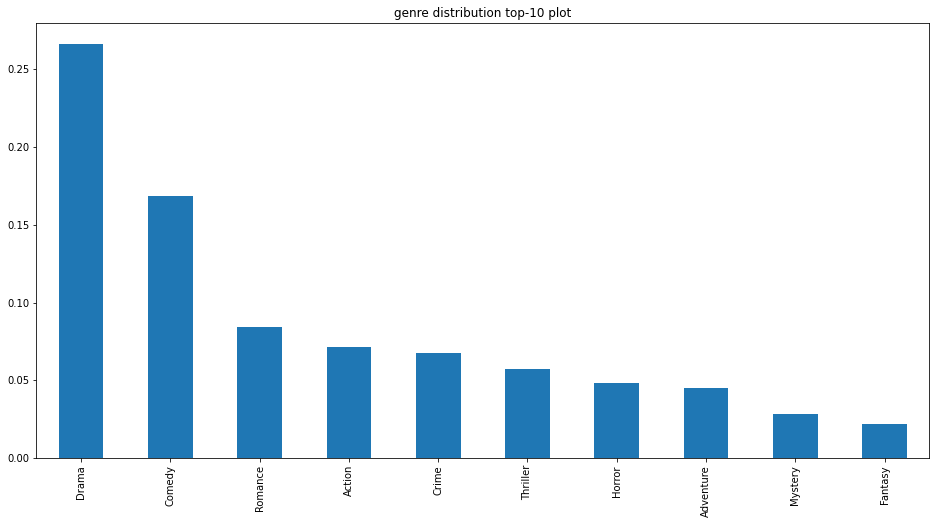

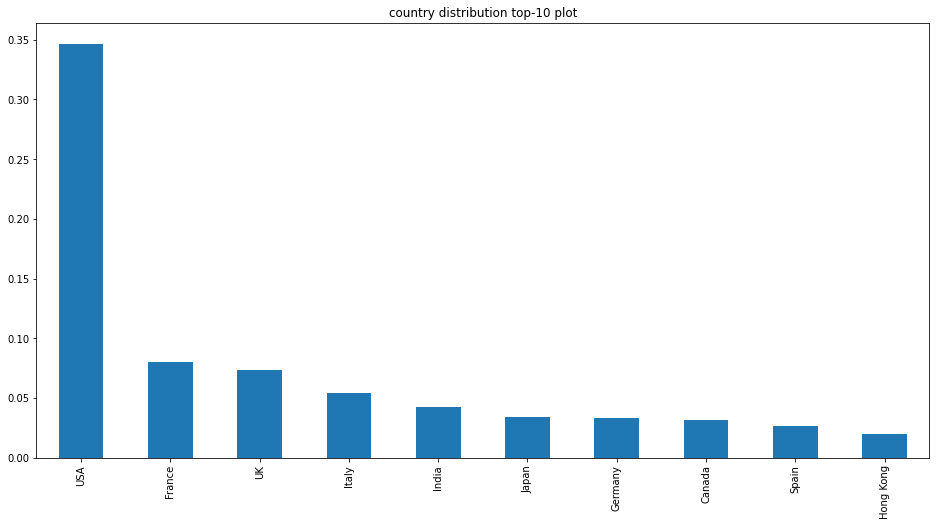

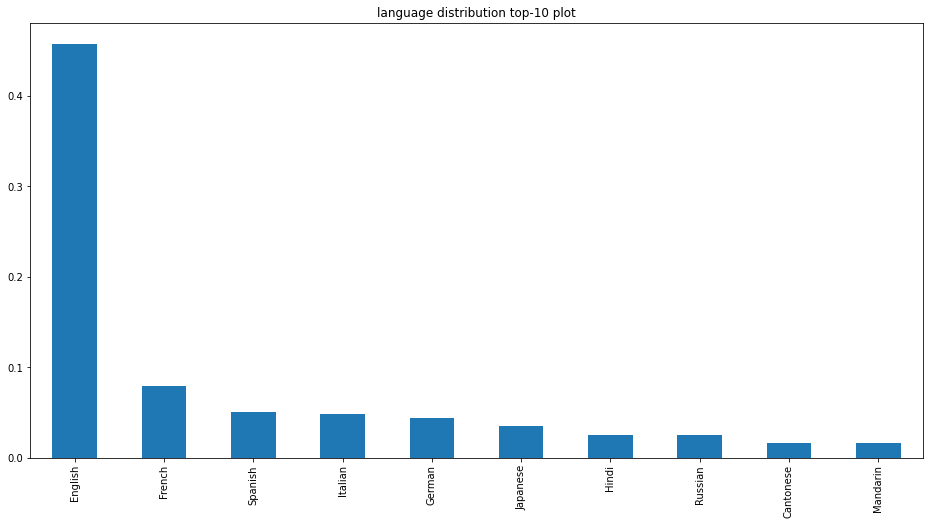

In [14]:
plt.rcParams["figure.figsize"] = (16,8)
plt.xticks(rotation=90)

obj_list = ['genre', 'country', 'language']
for obj in obj_list:
    plt.title(f'{obj} distribution top-10 plot')
    
    data_list = full_dataset[obj].str.split(', ').sum()
    pd.Series(data_list).value_counts(normalize=True)[:10].plot.bar()
    plt.show()

<AxesSubplot:title={'center':'currency distribution top-10 plot'}>

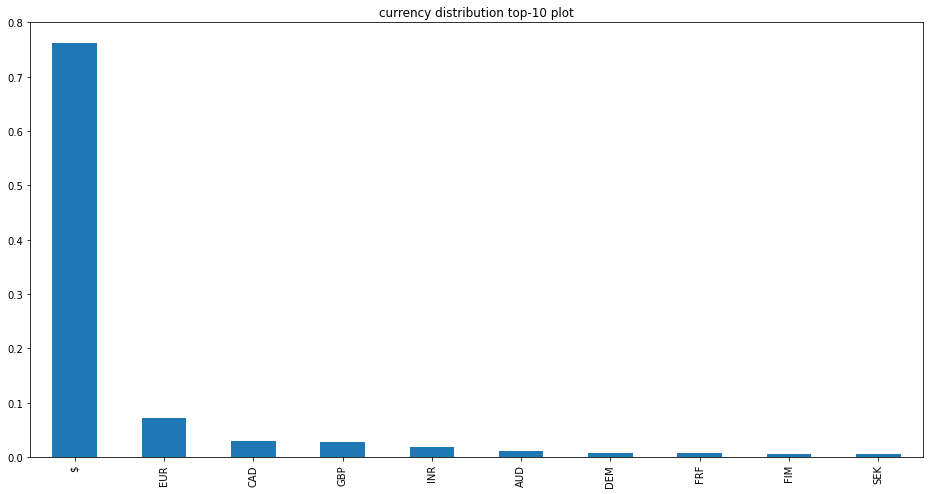

In [15]:
currency_distr = full_dataset['budget'].apply(lambda x: None if x is np.nan else x.split()[0])
plt.figure(figsize=(16,8))
plt.title("currency distribution top-10 plot")
pd.Series(currency_distr).value_counts(normalize=True)[:10].plot.bar()
# X_train["budget"].fillna("Nan !").str.split(" ").apply(lambda x: x[0]).value_counts()

In [16]:
# Make OHE features for special columns

for values in uniq_data.values():
    for value in values:
        full_dataset[value] = 0


for row, data in full_dataset.iterrows():
    for col in special_columns:
        value_list = data[col].split(', ')
        for value in value_list:
            if value in full_dataset.columns:
                full_dataset.loc[row, value] = 1


full_dataset = full_dataset.drop(special_columns, axis=1)


In [17]:
# Convert 'actors', 'director', 'writer' to count chars in string
peoples_list = ['actors', 'director', 'writer', 'description', 'production_company', 'title', 'original_title']

full_dataset[peoples_list] = full_dataset[peoples_list].fillna('No_Data')

for row, value in full_dataset[peoples_list].iterrows():
    for col in peoples_list:
        tmp_value = len(value[col])
        full_dataset.loc[row, col] = tmp_value

        
full_dataset.drop(['metascore','budget','usa_gross_income','worlwide_gross_income', 'imdb_title_id', 'date_published'], axis=1, inplace=True)


In [18]:
full_dataset['reviews_from_users'] = full_dataset['reviews_from_users'].apply(pd.to_numeric, errors='coerce')
full_dataset['reviews_from_critics'] = full_dataset['reviews_from_critics'].apply(pd.to_numeric, errors='coerce')

full_dataset['reviews_from_users'] = full_dataset['reviews_from_users'].fillna(full_dataset['reviews_from_users'].median())
full_dataset['reviews_from_critics'] = full_dataset['reviews_from_critics'].fillna(full_dataset['reviews_from_critics'].median())


In [19]:
dig_cols = ['votes', 'duration', 'reviews_from_users', 'reviews_from_critics'] + peoples_list

cat_cols = full_dataset.drop(dig_cols, axis=1).columns.tolist()

full_dataset.shape

(60198, 553)

In [20]:
[col for col in full_dataset.columns if full_dataset[col].isna().any() == True]

[]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(full_dataset, y, test_size=0.3, random_state=21)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42138, 553), (18060, 553), (42138,), (18060,))

In [22]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from collections import Counter

sm = KMeansSMOTE(random_state=42)

X_new, y_new = sm.fit_resample(X_train, y_train)

Counter(y_new).most_common()

[(1, 33396), (0, 33394)]

In [23]:
from catboost import CatBoostClassifier, Pool, cv

c_dataset = Pool(data=X_new,
                  label=y_new,
                cat_features=cat_cols)


params = {"iterations": 1000,
          "max_depth":6,
          "eval_metric":"F1",
          "l2_leaf_reg":1.0,
          "loss_function": "Logloss",
          "colsample_bylevel":0.5,
          "verbose": False}

scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.9040953372
bestIteration = 999

Training on fold [1/3]

bestTest = 0.9094242068
bestIteration = 880

Training on fold [2/3]

bestTest = 0.9112052731
bestIteration = 998



In [24]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [25]:
model_catb = CatBoostClassifier(random_state=21,cat_features=cat_cols)
model_catb.fit(X_new, y_new)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Learning rate set to 0.061956
0:	learn: 0.6194758	total: 14.7ms	remaining: 14.7s
1:	learn: 0.5480004	total: 25.4ms	remaining: 12.7s
2:	learn: 0.4926662	total: 35.3ms	remaining: 11.7s
3:	learn: 0.4491368	total: 45.2ms	remaining: 11.2s
4:	learn: 0.4136236	total: 55.5ms	remaining: 11.1s
5:	learn: 0.3902167	total: 65.7ms	remaining: 10.9s
6:	learn: 0.3679781	total: 76ms	remaining: 10.8s
7:	learn: 0.3494008	total: 86.6ms	remaining: 10.7s
8:	learn: 0.3343681	total: 96.3ms	remaining: 10.6s
9:	learn: 0.3241448	total: 106ms	remaining: 10.5s
10:	learn: 0.3150881	total: 116ms	remaining: 10.4s
11:	learn: 0.3085509	total: 126ms	remaining: 10.4s
12:	learn: 0.3020829	total: 135ms	remaining: 10.3s
13:	learn: 0.2945413	total: 145ms	remaining: 10.2s
14:	learn: 0.2882173	total: 155ms	remaining: 10.2s
15:	learn: 0.2844248	total: 165ms	remaining: 10.1s
16:	learn: 0.2817268	total: 174ms	remaining: 10.1s
17:	learn: 0.2798003	total: 184ms	remaining: 10s
18:	learn: 0.2751220	total: 196ms	remaining: 10.1s
19:	le

179:	learn: 0.2144820	total: 1.82s	remaining: 8.3s
180:	learn: 0.2142762	total: 1.83s	remaining: 8.3s
181:	learn: 0.2141515	total: 1.84s	remaining: 8.29s
182:	learn: 0.2140154	total: 1.85s	remaining: 8.28s
183:	learn: 0.2138458	total: 1.86s	remaining: 8.27s
184:	learn: 0.2137096	total: 1.87s	remaining: 8.26s
185:	learn: 0.2135925	total: 1.88s	remaining: 8.24s
186:	learn: 0.2135189	total: 1.89s	remaining: 8.23s
187:	learn: 0.2133558	total: 1.9s	remaining: 8.22s
188:	learn: 0.2132029	total: 1.91s	remaining: 8.21s
189:	learn: 0.2130717	total: 1.92s	remaining: 8.2s
190:	learn: 0.2128845	total: 1.93s	remaining: 8.19s
191:	learn: 0.2127472	total: 1.94s	remaining: 8.18s
192:	learn: 0.2125640	total: 1.95s	remaining: 8.17s
193:	learn: 0.2124373	total: 1.96s	remaining: 8.15s
194:	learn: 0.2122375	total: 1.97s	remaining: 8.14s
195:	learn: 0.2121151	total: 1.98s	remaining: 8.13s
196:	learn: 0.2119283	total: 1.99s	remaining: 8.12s
197:	learn: 0.2117800	total: 2s	remaining: 8.11s
198:	learn: 0.21159

345:	learn: 0.1955574	total: 3.44s	remaining: 6.49s
346:	learn: 0.1954994	total: 3.44s	remaining: 6.48s
347:	learn: 0.1954377	total: 3.46s	remaining: 6.47s
348:	learn: 0.1953747	total: 3.46s	remaining: 6.46s
349:	learn: 0.1953051	total: 3.48s	remaining: 6.46s
350:	learn: 0.1951890	total: 3.49s	remaining: 6.45s
351:	learn: 0.1951159	total: 3.5s	remaining: 6.44s
352:	learn: 0.1950514	total: 3.51s	remaining: 6.43s
353:	learn: 0.1949374	total: 3.52s	remaining: 6.42s
354:	learn: 0.1948635	total: 3.53s	remaining: 6.41s
355:	learn: 0.1947821	total: 3.54s	remaining: 6.4s
356:	learn: 0.1947085	total: 3.54s	remaining: 6.38s
357:	learn: 0.1946074	total: 3.55s	remaining: 6.37s
358:	learn: 0.1944729	total: 3.56s	remaining: 6.36s
359:	learn: 0.1943957	total: 3.57s	remaining: 6.35s
360:	learn: 0.1942960	total: 3.58s	remaining: 6.34s
361:	learn: 0.1942456	total: 3.59s	remaining: 6.33s
362:	learn: 0.1941609	total: 3.6s	remaining: 6.32s
363:	learn: 0.1939660	total: 3.61s	remaining: 6.31s
364:	learn: 0.1

515:	learn: 0.1828755	total: 5.06s	remaining: 4.75s
516:	learn: 0.1827905	total: 5.08s	remaining: 4.74s
517:	learn: 0.1826926	total: 5.08s	remaining: 4.73s
518:	learn: 0.1826861	total: 5.09s	remaining: 4.72s
519:	learn: 0.1826031	total: 5.1s	remaining: 4.71s
520:	learn: 0.1825510	total: 5.11s	remaining: 4.7s
521:	learn: 0.1824733	total: 5.12s	remaining: 4.69s
522:	learn: 0.1824174	total: 5.13s	remaining: 4.68s
523:	learn: 0.1823615	total: 5.14s	remaining: 4.67s
524:	learn: 0.1823006	total: 5.15s	remaining: 4.66s
525:	learn: 0.1822194	total: 5.16s	remaining: 4.65s
526:	learn: 0.1821451	total: 5.17s	remaining: 4.64s
527:	learn: 0.1820645	total: 5.18s	remaining: 4.63s
528:	learn: 0.1820085	total: 5.19s	remaining: 4.62s
529:	learn: 0.1819364	total: 5.2s	remaining: 4.61s
530:	learn: 0.1818894	total: 5.21s	remaining: 4.6s
531:	learn: 0.1818044	total: 5.22s	remaining: 4.59s
532:	learn: 0.1817313	total: 5.23s	remaining: 4.58s
533:	learn: 0.1816390	total: 5.24s	remaining: 4.58s
534:	learn: 0.18

685:	learn: 0.1730082	total: 6.68s	remaining: 3.06s
686:	learn: 0.1729597	total: 6.69s	remaining: 3.05s
687:	learn: 0.1728994	total: 6.7s	remaining: 3.04s
688:	learn: 0.1728403	total: 6.71s	remaining: 3.03s
689:	learn: 0.1727741	total: 6.72s	remaining: 3.02s
690:	learn: 0.1727237	total: 6.73s	remaining: 3.01s
691:	learn: 0.1726716	total: 6.74s	remaining: 3s
692:	learn: 0.1726213	total: 6.74s	remaining: 2.99s
693:	learn: 0.1725895	total: 6.75s	remaining: 2.98s
694:	learn: 0.1725300	total: 6.76s	remaining: 2.97s
695:	learn: 0.1724748	total: 6.77s	remaining: 2.96s
696:	learn: 0.1724193	total: 6.79s	remaining: 2.95s
697:	learn: 0.1723629	total: 6.8s	remaining: 2.94s
698:	learn: 0.1722687	total: 6.81s	remaining: 2.93s
699:	learn: 0.1722272	total: 6.82s	remaining: 2.92s
700:	learn: 0.1722211	total: 6.83s	remaining: 2.91s
701:	learn: 0.1721773	total: 6.84s	remaining: 2.9s
702:	learn: 0.1720893	total: 6.85s	remaining: 2.89s
703:	learn: 0.1720245	total: 6.86s	remaining: 2.88s
704:	learn: 0.1720

848:	learn: 0.1649818	total: 8.3s	remaining: 1.48s
849:	learn: 0.1649331	total: 8.31s	remaining: 1.47s
850:	learn: 0.1648833	total: 8.32s	remaining: 1.46s
851:	learn: 0.1648771	total: 8.33s	remaining: 1.45s
852:	learn: 0.1648372	total: 8.34s	remaining: 1.44s
853:	learn: 0.1647889	total: 8.35s	remaining: 1.43s
854:	learn: 0.1647539	total: 8.36s	remaining: 1.42s
855:	learn: 0.1647017	total: 8.37s	remaining: 1.41s
856:	learn: 0.1646539	total: 8.38s	remaining: 1.4s
857:	learn: 0.1645833	total: 8.39s	remaining: 1.39s
858:	learn: 0.1645440	total: 8.4s	remaining: 1.38s
859:	learn: 0.1645286	total: 8.4s	remaining: 1.37s
860:	learn: 0.1644623	total: 8.42s	remaining: 1.36s
861:	learn: 0.1644099	total: 8.43s	remaining: 1.35s
862:	learn: 0.1643692	total: 8.43s	remaining: 1.34s
863:	learn: 0.1643139	total: 8.44s	remaining: 1.33s
864:	learn: 0.1642582	total: 8.45s	remaining: 1.32s
865:	learn: 0.1642105	total: 8.46s	remaining: 1.31s
866:	learn: 0.1641624	total: 8.47s	remaining: 1.3s
867:	learn: 0.164

In [26]:
roc_auc_score(y_test, y_test_pred)

0.7414688335842325

In [27]:
f1_score(y_test, y_test_pred)

0.6253521126760563

### Part 3.

Train and compare the models

3.1. Select models, you are going to train, select hyperparameters that have to be tunes.

3.2 Use cross-validation to compare models and select best set of hyperparameters


In [39]:
from sklearn.model_selection import GridSearchCV

model = CatBoostClassifier(silent=True, iterations=100, rsm=0.1, 
                           learning_rate=0.1)
param_grid = {
    'depth': [2**x for x in range(2,4)],
    'l2_leaf_reg': [1, 10, 20]
}

grid = GridSearchCV(model, param_grid=param_grid, cv=4,
                    scoring="f1", verbose=10, refit=True)

grid.fit(X_new, y_new)

print(grid.best_score_)
display(pd.DataFrame(grid.cv_results_).sort_values('rank_test_score'))

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4; 1/6] START depth=4, l2_leaf_reg=1......................................
[CV 1/4; 1/6] END .......depth=4, l2_leaf_reg=1;, score=0.088 total time=   1.1s
[CV 2/4; 1/6] START depth=4, l2_leaf_reg=1......................................
[CV 2/4; 1/6] END .......depth=4, l2_leaf_reg=1;, score=0.959 total time=   0.8s
[CV 3/4; 1/6] START depth=4, l2_leaf_reg=1......................................
[CV 3/4; 1/6] END .......depth=4, l2_leaf_reg=1;, score=0.970 total time=   0.8s
[CV 4/4; 1/6] START depth=4, l2_leaf_reg=1......................................
[CV 4/4; 1/6] END .......depth=4, l2_leaf_reg=1;, score=0.973 total time=   0.9s
[CV 1/4; 2/6] START depth=4, l2_leaf_reg=10.....................................
[CV 1/4; 2/6] END ......depth=4, l2_leaf_reg=10;, score=0.079 total time=   0.7s
[CV 2/4; 2/6] START depth=4, l2_leaf_reg=10.....................................
[CV 2/4; 2/6] END ......depth=4, l2_leaf_reg=10;,

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_l2_leaf_reg,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.851645,0.122800,0.052723,0.041951,4,1,"{'depth': 4, 'l2_leaf_reg': 1}",0.087910,0.959489,0.969518,0.973190,0.747527,0.380863,1
5,1.396234,0.067990,0.027933,0.001702,8,20,"{'depth': 8, 'l2_leaf_reg': 20}",0.076976,0.961507,0.969124,0.973928,0.745384,0.385931,2
1,0.753437,0.021466,0.025355,0.000665,4,10,"{'depth': 4, 'l2_leaf_reg': 10}",0.078890,0.959631,0.969855,0.972793,0.745292,0.384779,3
4,1.396203,0.026415,0.042805,0.022036,8,10,"{'depth': 8, 'l2_leaf_reg': 10}",0.076296,0.959797,0.967944,0.975350,0.744847,0.386027,4
2,0.753312,0.016447,0.025574,0.000273,4,20,"{'depth': 4, 'l2_leaf_reg': 20}",0.076499,0.957132,0.969574,0.974610,0.744454,0.385696,5
3,1.350532,0.024529,0.026711,0.001045,8,1,"{'depth': 8, 'l2_leaf_reg': 1}",0.074117,0.961582,0.967832,0.973758,0.744322,0.386967,6


In [40]:
grid.best_params_

{'depth': 4, 'l2_leaf_reg': 1}

In [53]:
model_catb = CatBoostClassifier(cat_features=cat_cols, verbose=100)
model_catb.fit(X_new, y_new)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Learning rate set to 0.061956
0:	learn: 0.6063616	total: 12.2ms	remaining: 12.2s
100:	learn: 0.2269551	total: 948ms	remaining: 8.44s
200:	learn: 0.2111187	total: 1.87s	remaining: 7.45s
300:	learn: 0.1996341	total: 2.8s	remaining: 6.5s
400:	learn: 0.1908624	total: 3.71s	remaining: 5.55s
500:	learn: 0.1836326	total: 4.63s	remaining: 4.61s
600:	learn: 0.1776309	total: 5.54s	remaining: 3.68s
700:	learn: 0.1724889	total: 6.47s	remaining: 2.76s
800:	learn: 0.1675521	total: 7.38s	remaining: 1.83s
900:	learn: 0.1629862	total: 8.31s	remaining: 914ms
999:	learn: 0.1587497	total: 9.24s	remaining: 0us
TRAIN

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     33394
           1       0.87      0.63      0.73      8744

    accuracy                           0.90     42138
   macro avg       0.89      0.80      0.83     42138
weighted avg       0.90      0.90      0.90     42138

TEST

              precision    recall  f1-score   support

        

In [54]:
roc_auc_score(y_test, y_test_pred)

0.7419603720997862

In [55]:
f1_score(y_test, y_test_pred)

0.6267252195734002

3.3 Which model and setup is the best? How does it perform on the test dataset? If you were to present this model to the client, how would you describe it?